In [120]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sys
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import heapq
import itertools
import implicit
import pickle
import time
import operator

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from itertools import chain
from pathlib import Path
from implicit.als import AlternatingLeastSquares
from datetime import datetime
from implicit.nearest_neighbours import tfidf_weight
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, csr_matrix
from numpy import bincount, log, sqrt

## Load Datasets

In [121]:
df_order_products__prior = pd.read_csv("../data/raw/order_products__prior.csv")
df_order_products__train = pd.read_csv("../data/raw/order_products__train.csv")
df_orders = pd.read_csv("../data/raw/orders.csv") 
df_products = pd.read_csv("../data/raw/products.csv")

## Data Preparation

### User basket products

In [122]:
df_merged_order_products_prior = pd.merge(df_order_products__prior, df_products, on="product_id", how="left")

df_merged_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [123]:
df_merged_order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 7 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
product_name         object
aisle_id             int64
department_id        int64
dtypes: int64(6), object(1)
memory usage: 1.9+ GB


In [124]:
df_orders_users_train = df_orders.loc[(df_orders.eval_set == "train")].reset_index()
df_orders_users_train.head()

,index,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,10,1187899,1,train,11,4,8,14.0
1,25,1492625,2,train,15,1,11,30.0
2,49,2196797,5,train,5,0,11,6.0
3,74,525192,7,train,21,2,11,6.0
4,78,880375,8,train,4,1,14,10.0


In [125]:
df_orders_users_train.shape

(131209, 8)

In [126]:
df_orders_users_train = df_orders_users_train[["order_id", "user_id"]]
df_orders_users_train.head()

,order_id,user_id
0,1187899,1
1,1492625,2
2,2196797,5
3,525192,7
4,880375,8


In [127]:
df_order_products_test = df_order_products__train[["order_id", "product_id"]]
df_order_products_test.head()

,order_id,product_id
0,1,49302
1,1,11109
2,1,10246
3,1,49683
4,1,43633


In [128]:
df_order_products_test.shape

(1384617, 2)

In [129]:
df_order_products_test = df_order_products_test.groupby("order_id")["product_id"]\
                         .apply(list).reset_index().rename(columns={"product_id": "products"})
    
df_order_products_test.head()

,order_id,products
0,1,"[49302, 11109, 10246, 49683, 43633, 13176, 472..."
1,36,"[39612, 19660, 49235, 43086, 46620, 34497, 486..."
2,38,"[11913, 18159, 4461, 21616, 23622, 32433, 2884..."
3,96,"[20574, 30391, 40706, 25610, 27966, 24489, 39275]"
4,98,"[8859, 19731, 43654, 13176, 4357, 37664, 34065..."


In [130]:
df_order_products_test.shape

(131209, 2)

In [131]:
df_user_products_test = pd.merge(df_orders_users_train, df_order_products_test, on="order_id")
df_user_products_test.head()

,order_id,user_id,products
0,1187899,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,1492625,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,2196797,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,525192,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,880375,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."


In [132]:
df_user_products_test = df_user_products_test[["user_id", "products"]]
df_user_products_test.head()

,user_id,products
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."


In [133]:
df_user_products_test.to_csv("../data/interim/user_products__test.csv", index_label=False)

### Users prior purchases per product

In [134]:
df_order_user_prior = df_orders.loc[df_orders.eval_set == "prior"]
df_order_user_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [135]:
df_order_user_prior.shape

(3214874, 7)

In [136]:
df_order_user_prior = df_order_user_prior[["order_id", "user_id"]]
df_order_user_prior.head()

,order_id,user_id
0,2539329,1
1,2398795,1
2,473747,1
3,2254736,1
4,431534,1


In [137]:
df_user_product_prior = pd.merge(df_order_user_prior, df_order_products__prior[["order_id", "product_id"]],\
                                 on="order_id")
df_user_product_prior.head()

,order_id,user_id,product_id
0,2539329,1,196
1,2539329,1,14084
2,2539329,1,12427
3,2539329,1,26088
4,2539329,1,26405


In [138]:
df_user_product_prior = df_user_product_prior[["user_id", "product_id"]]
df_user_product_prior = df_user_product_prior.groupby(["user_id", "product_id"])\
                                                      .size().reset_index().rename(columns={0:"quantity"})
df_user_product_prior.head() 

,user_id,product_id,quantity
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [139]:
df_user_product_prior.shape

(13307953, 3)

In [140]:
df_user_product_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 3 columns):
user_id       int64
product_id    int64
quantity      int64
dtypes: int64(3)
memory usage: 304.6 MB


In [141]:
df_user_product_prior["user_id"] = df_user_product_prior["user_id"].astype("category")
df_user_product_prior["product_id"] = df_user_product_prior["product_id"].astype("category")

df_user_product_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 3 columns):
user_id       category
product_id    category
quantity      int64
dtypes: category(2), int64(1)
memory usage: 216.3 MB


In [142]:
df_user_product_prior.to_csv("../data/interim/user_products__prior.csv", index_label=False)

## Utility Matrix

In [143]:
utility_matrix = sparse.coo_matrix((df_user_product_prior["quantity"],
                                        (df_user_product_prior["product_id"].cat.codes.copy(),
                                         df_user_product_prior["user_id"].cat.codes.copy())))

utility_matrix.shape

(49677, 206209)

In [144]:
sparse.save_npz("../data/interim/utility_matrix.npz", utility_matrix)

In [145]:
utility_matrix = utility_matrix.T.tocsr().astype(np.float32)

## Singular-value Decomposition 

Calculate the product and user factors with a number of factors = 50.

In [146]:
user_factors_50, singular_values_50,product_factors_50 = linalg.svds(utility_matrix, 50)

In [147]:
product_factors_50.shape

(50, 49677)

In [148]:
singular_values_50.shape

(50,)

In [149]:
user_factors_50.shape

(206209, 50)

In [150]:
# changing to user* factor format
user_factors_50=user_factors_50*singular_values_50

In [151]:
user_factors_50.shape

(206209, 50)

In [152]:
# saving the user and product factors
np.save("../data/interim/product_factor_50.npy", product_factors_50)
np.save("../data/interim/user_factor_50", user_factors_50)

### Example Recommendations

In [153]:
# Maps user_id: user index
u_dict = {uid:i for i, uid in enumerate(df_user_product_prior["user_id"].cat.categories)}
len(u_dict)

206209

In [154]:
p_dict = dict(enumerate(df_user_product_prior["product_id"].cat.categories))
len(p_dict)

49677

We'll use user 1 for this example

In [155]:
user_id = 1

Actual products bought by user 1

In [156]:
row = df_user_products_test.loc[df_user_products_test.user_id == user_id]
actual = list(row["products"])[0]
actual

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

In [157]:
act_products = []
for pid in actual:
    act_products.extend((df_products.loc[df_products.product_id == pid].product_name).tolist())
print("Actual products bought by user {}\n{}\n\n".format(user_id, act_products))

Actual products bought by user 1
['Soda', 'Organic String Cheese', '0% Greek Strained Yogurt', 'XL Pick-A-Size Paper Towel Rolls', 'Milk Chocolate Almonds', 'Pistachios', 'Cinnamon Toast Crunch', 'Aged White Cheddar Popcorn', 'Organic Whole Milk', 'Organic Half & Half', 'Zero Calorie Cola']




In [158]:
scores =  user_factors_50[u_dict[user_id]].dot(product_factors_50)
best = np.argpartition(scores, -10)[-10:]
recommendations_all = sorted(zip(best, scores[best]), key=lambda x: -x[1])
recommendations_all

[(195, 4.8402233),
 (6181, 2.9733458),
 (38920, 2.1561551),
 (13172, 1.9325089),
 (49224, 1.8926617),
 (37702, 1.8685515),
 (13571, 1.64328),
 (31645, 1.33069),
 (46139, 1.2746842),
 (32472, 1.1251252)]

Best recommended products for user 1

In [159]:
all_recm_products=[]
for recommend in recommendations_all:
    all_recm_products.extend((df_products.loc[df_products.product_id == p_dict[recommend[0]]].product_name).tolist())
print("All products recommended to user {}\n{}\n\n".format(user_id, all_recm_products))

All products recommended to user 1
['Soda', 'Clementines', '0% Greek Strained Yogurt', 'Bag of Organic Bananas', 'Organic Half & Half', 'Trail Mix', 'Apples', 'Extra Fancy Unsalted Mixed Nuts', 'Zero Calorie Cola', 'Reduced Fat 2% Milk']




In [160]:
bought_indices = utility_matrix[u_dict[user_id]].nonzero()[1]
count = 10 + len(bought_indices)
ids = np.argpartition(scores, -count)[-count:]
best = sorted(zip(ids, scores[ids]), key=lambda x: -x[1])        
recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))

New products not previously bought recommended for user 1 

In [161]:
new_recm_products=[]
for recommend in recommendations_new:
    new_recm_products.extend((df_products.loc[df_products.product_id == p_dict[recommend[0]]].product_name).tolist())
print("New products recommended to user {}\n{}".format(user_id, new_recm_products))

New products recommended to user 1
['Clementines', 'Trail Mix', 'Apples', 'Extra Fancy Unsalted Mixed Nuts', 'Reduced Fat 2% Milk', 'Sparkling Mineral Water', "Crunchy Oats 'n Honey Granola Bars", 'Mixed Fruit Fruit Snacks', 'Mozzarella String Cheese', 'Popcorn']


A lot of lowfat greek yogurt recommendations!

### Evaluation

In [162]:
# Transpose of the product_user utility matrix
utility_matrix_T = utility_matrix.T.tocsr()

In [163]:
# Number of recommendations to make for every user
N_REC = 10

In [164]:
# Get the `N_REC` most popular products for comparison
popular_products = list(df_order_products__prior["product_id"].value_counts().head(N_REC).index)

In [165]:
popular_products

[24852, 13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209, 27845]

In [166]:
subset = 0.2  # Evaluate on 20% of the dataset

In [167]:
df_eval = df_user_products_test.copy()
df_eval = df_eval.sample(n=int(len(df_eval) * subset), random_state=7).reset_index(drop=True)
df_eval.head()

,user_id,products
0,96827,"[1947, 13176, 28199, 25230, 33081, 3896, 5450,..."
1,32474,"[9203, 26940, 11286, 27012, 17652, 18677, 3877..."
2,3492,"[22959, 26604, 10867, 7349, 48527, 13866, 1136..."
3,156404,[48762]
4,89919,"[35221, 13176, 11520, 7503, 26209, 13984, 2283..."


In [168]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26241 entries, 0 to 26240
Data columns (total 2 columns):
user_id     26241 non-null int64
products    26241 non-null object
dtypes: int64(1), object(1)
memory usage: 410.1+ KB


The columns of products bought by the user in the past and new products in the cart will help evaluate the recall of each recommender model. 

In [169]:
def past_products(row):
    return set([p_dict[i] for i in utility_matrix[u_dict[row["user_id"]]].indices]) 

def new_products(row):
    return set(row['products']) - set(row['past_products'])

In [170]:
df_eval['past_products'] = df_eval.apply(past_products, axis=1)

df_eval['new_products'] = df_eval.apply(new_products, axis=1)

df_eval.head()

,user_id,products,past_products,new_products
0,96827,"[1947, 13176, 28199, 25230, 33081, 3896, 5450,...","{30727, 45066, 47626, 21526, 30233, 45083, 159...","{20169, 939, 9422, 33081, 1947}"
1,32474,"[9203, 26940, 11286, 27012, 17652, 18677, 3877...","{11777, 14852, 8710, 47626, 11286, 15396, 2819...","{16521, 27012}"
2,3492,"[22959, 26604, 10867, 7349, 48527, 13866, 1136...","{18439, 7693, 47119, 31766, 17949, 20514, 2563...",{}
3,156404,[48762],"{44904, 19819, 7249, 13176, 48762, 8571}",{}
4,89919,"[35221, 13176, 11520, 7503, 26209, 13984, 2283...","{1540, 10246, 45578, 19467, 33294, 22031, 2612...","{13984, 10920, 22831}"


In [171]:
def recall_popular(row):
    past_products = set(row['past_products'])
    new_products = set(row['new_products'])
    
    if len(new_products) == 0:
        return 0
    
    new_prods, pop = set(new_products), set(popular_products)

    return len(new_prods.intersection(pop)) / len(new_products)

df_eval['Recall_Top_Recommended'] = df_eval.apply(recall_popular, axis=1)

In [172]:
print("Popular recommendations recall: {:.2f}%".format(df_eval.Recall_Top_Recommended.mean() * 100))

Popular recommendations recall: 2.62%


In [173]:
def recall_SVD(row):
    past_products = set(row['past_products'])
    new_products = set(row['new_products'])
    if len(new_products) == 0:
        return 0

    scores =  user_factors_50[u_dict[row["user_id"]]].dot(product_factors_50)
    bought_indices = utility_matrix[u_dict[row["user_id"]]].nonzero()[1]

    count = 10 + len(bought_indices)
    ids = np.argpartition(scores, -count)[-count:]
    best = sorted(zip(ids, scores[ids]), key=lambda x: -x[1])

    recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))
        
    SVD_recommends = [p_dict[r[0]] for r in recommendations_new]  
    new_prods, pred = set(new_products), set(SVD_recommends)

    return len(new_prods.intersection(pred)) / len(new_products)

df_eval['Recall_SVD'] = df_eval.apply(recall_SVD, axis=1)

In [174]:
print("SVD recommendations recall: {:.2f}%".format(df_eval.Recall_SVD.mean() * 100))

SVD recommendations recall: 2.84%


The 50 factor SVD performs slightly better than the Baseline Model, but we can try searching for the best factor parameter.

### SVD Optimization

In [175]:
def recall_SVD_factor(row, user_factors, product_factors):
    past_products = set(row['past_products'])
    new_products = set(row['new_products'])
    if len(new_products) == 0:
        return 0

    scores =  user_factors[u_dict[row["user_id"]]].dot(product_factors)

    bought_indices = utility_matrix[u_dict[row["user_id"]]].nonzero()[1]

    count = 10 + len(bought_indices)
    ids = np.argpartition(scores, -count)[-count:]
    best = sorted(zip(ids, scores[ids]), key=lambda x: -x[1])

    recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))
        
    SVD_recommends = [p_dict[r[0]] for r in recommendations_new]  
    new_prods, pred = set(new_products), set(SVD_recommends)

    return len(new_prods.intersection(pred)) / len(new_products)

In [176]:
factor_list = chain(range(1,10), range(10,70,10))
SVD_factor_recalls = {}

for factor in factor_list:
    print("Starting factor",factor)
    #Calculating the product and user factors
    user_factors, singular_values,product_factors = linalg.svds(utility_matrix, factor)
    user_factors=user_factors*singular_values
    
    df_eval[factor] = df_eval.apply(recall_SVD_factor,args=(user_factors, product_factors), axis=1)
    SVD_factor_recalls[factor] = df_eval[factor].mean() * 100

Starting factor 1
Starting factor 2
Starting factor 3
Starting factor 4
Starting factor 5
Starting factor 6
Starting factor 7
Starting factor 8
Starting factor 9
Starting factor 10
Starting factor 20
Starting factor 30
Starting factor 40
Starting factor 50
Starting factor 60


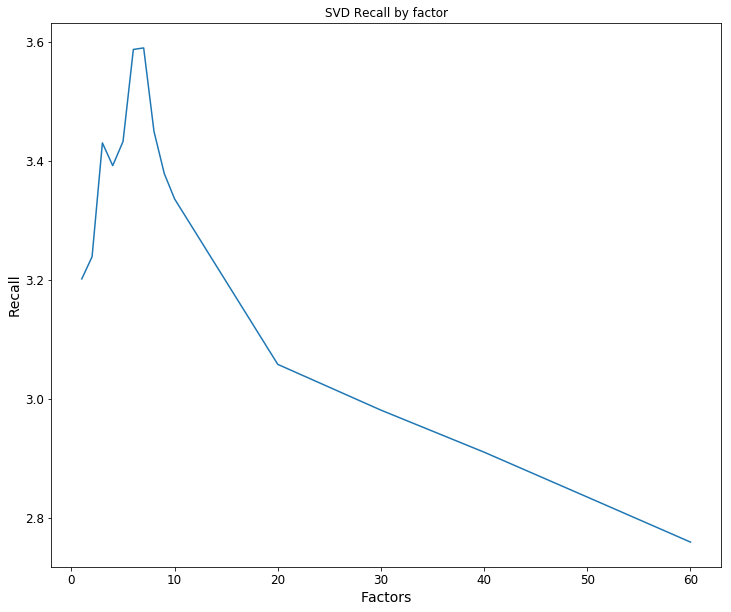

In [177]:
plt.figure(figsize=(12,10))
plt.plot(SVD_factor_recalls.keys(),SVD_factor_recalls.values())
plt.ylabel('Recall')
plt.xlabel('Factors')
plt.title('SVD Recall by factor')
plt.show()

In [178]:
max_recall = max(SVD_factor_recalls.values())
best_factor = list(SVD_factor_recalls.keys())[list(SVD_factor_recalls.values()).index(max_recall)]
print("SVD Best number of factors is {} with a recall of {}.".format(best_factor,max_recall))

SVD Best number of factors is 7 with a recall of 3.589555804546938.


## Implicit Matrix Factorization using ALS

In [179]:
#Fix to get ALS library to work as fast as possible
%env OPENBLAS_NUM_THREADS=1

env: OPENBLAS_NUM_THREADS=1


In [180]:
def build_imf(utility_matrix, alpha):
    model = AlternatingLeastSquares()
    model.approximate_similar_items = False
    model.fit((utility_matrix * alpha).astype("double"))
    
    return model

imf_model = build_imf(utility_matrix.T, 10)

### Example Recommendation

In [181]:
recommendations = imf_model.recommend(u_dict[user_id], utility_matrix.T, N = 10)

In [182]:
row = df_user_products_test.loc[df_user_products_test.user_id == user_id]
actual = list(row["products"])[0]
actual

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

In [183]:
act_products = []
for pid in actual:
    act_products.extend((df_products.loc[df_products.product_id == pid].product_name).tolist())
print("Actual products bought by user {}\n{}\n\n".format(user_id, act_products))

Actual products bought by user 1
['Soda', 'Organic String Cheese', '0% Greek Strained Yogurt', 'XL Pick-A-Size Paper Towel Rolls', 'Milk Chocolate Almonds', 'Pistachios', 'Cinnamon Toast Crunch', 'Aged White Cheddar Popcorn', 'Organic Whole Milk', 'Organic Half & Half', 'Zero Calorie Cola']




Recommended products

In [184]:
new_recm_products=[]
for recommend in recommendations:
    new_recm_products.extend((df_products.loc[df_products.product_id == p_dict[recommend[0]]].product_name).tolist())
print("New products recommended to user {}\n{}".format(user_id, new_recm_products))

New products recommended to user 1
['Soda', 'Trail Mix', 'Organic Half & Half', 'Extra Fancy Unsalted Mixed Nuts', 'Zero Calorie Cola', 'Bag of Organic Bananas', 'Original Beef Jerky', '0% Greek Strained Yogurt', "Crunchy Oats 'n Honey Granola Bars", 'Mineral Water']


### Evaluation

In [185]:
df_eval.head()

,user_id,products,past_products,new_products,Recall_Top_Recommended,Recall_SVD,1,2,3,4,...,6,7,8,9,10,20,30,40,50,60
0,96827,"[1947, 13176, 28199, 25230, 33081, 3896, 5450,...","{30727, 45066, 47626, 21526, 30233, 45083, 159...","{20169, 939, 9422, 33081, 1947}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32474,"[9203, 26940, 11286, 27012, 17652, 18677, 3877...","{11777, 14852, 8710, 47626, 11286, 15396, 2819...","{16521, 27012}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3492,"[22959, 26604, 10867, 7349, 48527, 13866, 1136...","{18439, 7693, 47119, 31766, 17949, 20514, 2563...",{},0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,156404,[48762],"{44904, 19819, 7249, 13176, 48762, 8571}",{},0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89919,"[35221, 13176, 11520, 7503, 26209, 13984, 2283...","{1540, 10246, 45578, 19467, 33294, 22031, 2612...","{13984, 10920, 22831}",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
df_eval.drop([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60], axis=1, inplace=True)

In [187]:
df_eval.head()

,user_id,products,past_products,new_products,Recall_Top_Recommended,Recall_SVD
0,96827,"[1947, 13176, 28199, 25230, 33081, 3896, 5450,...","{30727, 45066, 47626, 21526, 30233, 45083, 159...","{20169, 939, 9422, 33081, 1947}",0.0,0.0
1,32474,"[9203, 26940, 11286, 27012, 17652, 18677, 3877...","{11777, 14852, 8710, 47626, 11286, 15396, 2819...","{16521, 27012}",0.0,0.0
2,3492,"[22959, 26604, 10867, 7349, 48527, 13866, 1136...","{18439, 7693, 47119, 31766, 17949, 20514, 2563...",{},0.0,0.0
3,156404,[48762],"{44904, 19819, 7249, 13176, 48762, 8571}",{},0.0,0.0
4,89919,"[35221, 13176, 11520, 7503, 26209, 13984, 2283...","{1540, 10246, 45578, 19467, 33294, 22031, 2612...","{13984, 10920, 22831}",0.0,0.0


In [188]:
def recall_IMF(row):
    past_products = set(row['past_products'])
    new_products = set(row['new_products'])
    if len(new_products) == 0:
        return 0

    bought_indices = utility_matrix[u_dict[row["user_id"]]].nonzero()[1]
    best = imf_model.recommend(u_dict[row["user_id"]], utility_matrix, N = 10)
    recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))
    
    IMF_recommends = [p_dict[r[0]] for r in recommendations_new]  
    new_prods, pred = set(new_products), set(IMF_recommends)

    return len(new_prods.intersection(pred)) / len(new_products)

df_eval['Recall_IMF'] = df_eval.apply(recall_IMF, axis=1)

In [189]:
print("IMF recommendations recall: {:.2f}%".format(df_eval.Recall_IMF.mean() * 100))

IMF recommendations recall: 4.31%


### IMF Optimization

Defining the alphas that we will analyze

In [190]:
alpha_list = range(3,20,1)

In [191]:
IMF_alpha_recalls = {}

for alpha in alpha_list:
    print("Starting alpha",alpha)

    imf_model = build_imf(utility_matrix.T, alpha);
    
    df_eval[alpha] = df_eval.apply(recall_IMF, axis=1)
    IMF_alpha_recalls[alpha] = df_eval[alpha].mean() * 100

Starting alpha 3
Starting alpha 4
Starting alpha 5
Starting alpha 6
Starting alpha 7
Starting alpha 8
Starting alpha 9
Starting alpha 10
Starting alpha 11
Starting alpha 12
Starting alpha 13
Starting alpha 14
Starting alpha 15
Starting alpha 16
Starting alpha 17
Starting alpha 18
Starting alpha 19


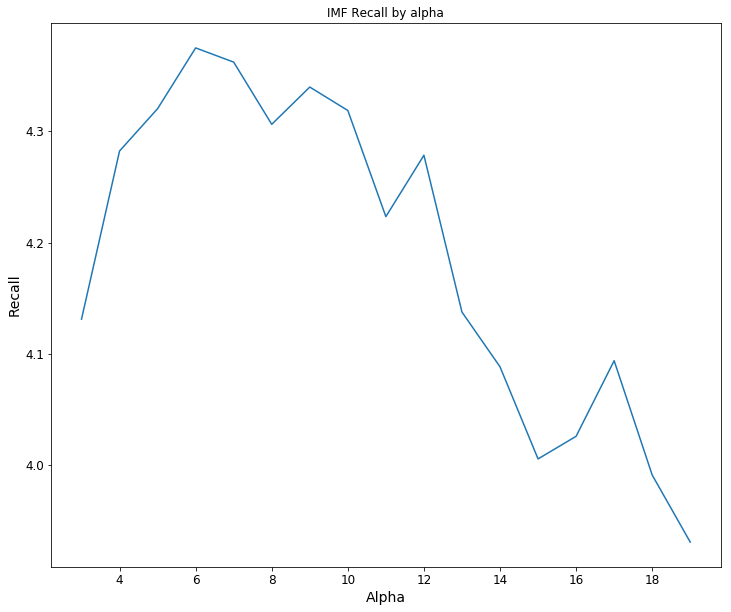

In [192]:
plt.figure(figsize=(12,10))
plt.plot(IMF_alpha_recalls.keys(),IMF_alpha_recalls.values())
plt.ylabel('Recall')
plt.xlabel('Alpha')
plt.title('IMF Recall by alpha')
plt.show()

In [193]:
max_recall = max(IMF_alpha_recalls.values())
best_alpha = list(IMF_alpha_recalls.keys())[list(IMF_alpha_recalls.values()).index(max_recall)]
print("SVD Best number of factors is {} with a recall of {}.".format(best_alpha,max_recall))

SVD Best number of factors is 6 with a recall of 4.3748216552149275.


We get more than a 20% increase in performance with the IMF model.